In [3]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
data_path = kagglehub.competition_download('fake-or-real-the-impostor-hunt')

print('Data source import complete.')

Data source import complete.


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
def data_import(dir_path):
  rows = []

  for f_num, folder_name in enumerate(sorted(os.listdir(dir_path))):
    folder_path = os.path.join(dir_path, folder_name)
    file1_path = os.path.join(folder_path, "file_1.txt")
    file2_path = os.path.join(folder_path, "file_2.txt")

    with open(file1_path, encoding="utf-8") as f1:
        text1 = f1.read()
    with open(file2_path, encoding="utf-8") as f2:
        text2 = f2.read()

    rows.append({
            'id': f_num,
            'text1': text1,
            'text2': text2
        })

  print(f"Done with number of articles: {f_num + 1}")

  return pd.DataFrame(rows)

In [8]:
train_csv = pd.read_csv(os.path.join(data_path, 'data/train.csv'))
train_path = os.path.join(data_path, 'data/train')
test_path = os.path.join(data_path, 'data/test')

train_data = data_import(train_path)
test_data = data_import(test_path)

Done with number of articles: 95
Done with number of articles: 1068


In [9]:
train_data.shape

(95, 3)

In [10]:
test_data.shape

(1068, 3)

File with ground truth for training samples

In [11]:
train_csv.shape

(95, 2)

In [12]:
train_csv.head()

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


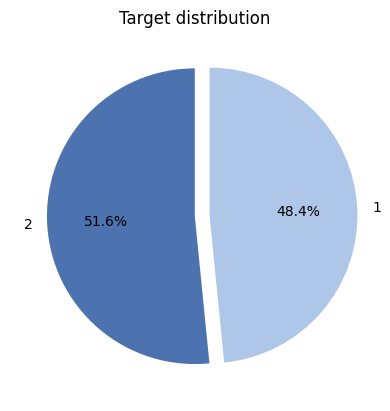

In [13]:
train_csv['real_text_id'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0,0.1), colors=['#4c72b0', '#aec7e8'])
plt.title('Target distribution')
plt.ylabel('')
plt.show()

# EDA

In [14]:
train_data.head()

,id,text1,text2
0,0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...
2,2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...
4,4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...


In [15]:
missing_table = pd.DataFrame({
    'Missing Values': train_data.isna().sum(),
    'Percentage (%)': (train_data.isnull().mean() * 100).round(2)
})

print(missing_table.sort_values(by='Missing Values', ascending=False))

       Missing Values  Percentage (%)
id                  0             0.0
text1               0             0.0
text2               0             0.0


In [16]:
train_df = train_data.merge(train_csv, on="id")
rows = []

for _, row in train_df.iterrows():
    if row['real_text_id'] == 1:
        rows.append({'pair_id': row['id'], 'text': row['text1'], 'target': 1})
        rows.append({'pair_id': row['id'], 'text': row['text2'], 'target': 0})
    else:
        rows.append({'pair_id': row['id'], 'text': row['text1'], 'target': 0})
        rows.append({'pair_id': row['id'], 'text': row['text2'], 'target': 1})

binary_df = pd.DataFrame(rows)

In [17]:
binary_df.shape

(190, 3)

In [18]:
binary_df.head(10)

,pair_id,text,target
0,0,The VIRSA (Visible Infrared Survey Telescope A...,1
1,0,The China relay network has released a signifi...,0
2,1,China\nThe goal of this project involves achie...,0
3,1,The project aims to achieve an accuracy level ...,1
4,2,Scientists can learn about how galaxies form a...,1
5,2,Dinosaur eggshells offer clues about what dino...,0
6,3,China\nThe study suggests that multiple star s...,0
7,3,The importance for understanding how stars evo...,1
8,4,Dinosaur Rex was excited about his new toy set...,0
9,4,Analyzing how fast stars rotate within a galax...,1


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
unique_pairs = binary_df['pair_id'].unique()
train_pairs, val_pairs = train_test_split(unique_pairs, test_size=0.2, random_state=42)

train_df = binary_df[binary_df['pair_id'].isin(train_pairs)].reset_index(drop=True)
val_df   = binary_df[binary_df['pair_id'].isin(val_pairs)].reset_index(drop=True)

In [21]:
train_df.head()

,pair_id,text,target
0,1,China\nThe goal of this project involves achie...,0
1,1,The project aims to achieve an accuracy level ...,1
2,2,Scientists can learn about how galaxies form a...,1
3,2,Dinosaur eggshells offer clues about what dino...,0
4,3,China\nThe study suggests that multiple star s...,0


In [22]:
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

X_val = val_df.drop('target', axis=1)
y_val = val_df['target']

# Model building

In [23]:
import torch
import torch.nn as nn
import transformers
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import BCELoss
from collections import Counter, defaultdict
from transformers import AutoModel, AutoTokenizer

In [24]:
bert_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

In [25]:
X_train_token = tokenizer(X_train["text"].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=256)
X_val_token = tokenizer(X_val["text"].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=256)

In [26]:
class RealFakeDataset(Dataset):
  def __init__(self, data, pair_id, labels=None):
    self.data = data
    self.pair_id = list(pair_id)
    self.labels = list(labels) if labels is not None else None

  def __len__(self):
    return len(self.data["input_ids"])

  def __getitem__(self, idx):
    item = {k: v[idx] for k, v in self.data.items()}
    item["pair_id"] = torch.tensor(self.pair_id[idx])
    if self.labels is not None:
      item["labels"] = torch.tensor(self.labels[idx])
    return item

In [27]:
train_dataset = RealFakeDataset(X_train_token, X_train["pair_id"], y_train)
val_dataset = RealFakeDataset(X_val_token, X_val["pair_id"], y_val)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [29]:
class RealFakeModel(nn.Module):
  def __init__(self, bert_model, hidden_dim1, hidden_dim2, output_dim):
    super(RealFakeModel, self).__init__()
    self.bert = bert_model
    embedding_dim = bert_model.config.hidden_size

    self.out = nn.Sequential(
        nn.Linear(embedding_dim, hidden_dim1),
        nn.Dropout(0.3),
        nn.ReLU(),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.Dropout(0.2),
        nn.Linear(hidden_dim2, output_dim)
        )

  def forward(self, input_ids, attn_mask):
    bert_output = self.bert(input_ids=input_ids, attention_mask=attn_mask)
    output = bert_output.last_hidden_state[:, 0, :]
    output = self.out(output)
    return output

In [30]:
model = RealFakeModel(bert_model, hidden_dim1=128, hidden_dim2=64, output_dim=1)

In [31]:
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2, eps = 1e-7)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# counter = Counter(y)
# weights = torch.tensor([counter[0] / counter[1]], dtype=torch.float).to(device)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(5):
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].unsqueeze(1).float().to(device)

        outputs = model(input_ids=input_ids, attn_mask=attention_mask)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1} complete")

    model.eval()
    correct = 0
    total = 0
    pair_scores = defaultdict(list)

    with torch.no_grad():
        for batch in val_loader:
            print(len(batch["input_ids"]))
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].unsqueeze(1).float().to(device)
            pair_ids = batch["pair_id"].cpu().numpy()

            outputs = model(input_ids=input_ids, attn_mask=attention_mask)
            probs = torch.sigmoid(outputs)
            print(probs)

            for pid, prob, label in zip(pair_ids, probs, labels):
              pair_scores[pid].append((prob.item(), label.item()))

    print(len(pair_scores))
    correct_pairs = 0
    total_pairs = 0
    for pid, items in pair_scores.items():
      if len(items) != 2:
        continue
      chosen = max(items, key=lambda x: x[0])
      if chosen[1] == 1:
        correct_pairs += 1
      total_pairs += 1

    pairwise_acc = correct_pairs / total_pairs
    print(f"Pairwise Accuracy: {pairwise_acc:.4f}")
    print(total_pairs)

# Test data preprocessing

In [86]:
rows = []

for _, row in test_data.iterrows():
  rows.append({'pair_id': row['id'], 'text': row['text1']})
  rows.append({'pair_id': row['id'], 'text': row['text2']})

test_binary = pd.DataFrame(rows)

In [88]:
test_data.head()

,id,text1,text2
0,0,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...
1,1,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...
2,2,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...
3,3,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor..."
4,4,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...


In [87]:
test_binary.head(10)

,pair_id,text
0,0,"""Music"" Music music music Music music Music mu..."
1,0,Since its launch on Paranal observatory's Very...
2,1,underground exploration on SN's birth has prov...
3,1,SN 1987A provides valuable insights as newer o...
4,2,This research aimed to understand how star sha...
5,2,ChromeDriver music player\nThis study focused ...
6,3,Using OmegaCAM's wide field capabilities spann...
7,3,"greek translation :\nvazhi (megaCAM), territor..."
8,4,AssemblyCulture AssemblyCulture AssemblyCultur...
9,4,XClass is software tool that helps astronomers...


In [90]:
test_token = tokenizer(test_binary["text"].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=256)

In [91]:
test_dataset = RealFakeDataset(test_token, test_binary["pair_id"])
test_loader =  DataLoader(train_dataset, batch_size=32, shuffle=False)

In [100]:
model.eval()
submission = []
pair_scores = defaultdict(list)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pair_ids = batch["pair_id"].cpu().numpy()

        outputs = model(input_ids=input_ids, attn_mask=attention_mask)
        probs = torch.sigmoid(outputs)

        for pid, prob in zip(pair_ids, probs):
          pair_scores[pid].append(prob.item())

print(len(pair_scores))
for pid, items in pair_scores.items():
  if len(items) != 2:
    continue
  probs = [items[0], items[1]]
  chosen_index = 1 if items[0] > items[1] else 2
  submission.append({"id": pid, "label": chosen_index})

2


In [101]:
submission_df = pd.DataFrame(submission)

submission_df

,id,label
0,1,2


In [ ]:
submission_df.to_csv('submission.csv', index=False)